# library

In [162]:
import gc
import itertools
from copy import deepcopy

import numpy as np
import pandas as pd

from tqdm import tqdm

from scipy.stats import ks_2samp

from sklearn.preprocessing import scale, MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import FastICA
from sklearn.decomposition import PCA
from sklearn.random_projection import GaussianRandomProjection
from sklearn.random_projection import SparseRandomProjection

from sklearn import manifold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.ticker import NullFormatter
import os
%matplotlib inline
import warnings
warnings.filterwarnings(action='ignore')

plt.style.use('ggplot') #ggplot스타일 사용
rcParams['figure.figsize'] = (16, 8)
plt.rc('axes', unicode_minus=False)
pd.set_option('max_columns', 100)

- real world predict(covariate(공변량) shift)

    - train, test distribution different
        - 학습셋으로 모델을 학습시켜도 실제 예측해야하는 테스트셋과 분포가 다르다면 원하는 예측 방향으로 흘러가지 않을 수 있음
        - 따라서 실제 테스트 셋에서의 예측력을 높이기 위해서는 두 데이터의 분포를 맞춰주는 것이 용이할 수 있음
    - 참고글
        - https://data-newbie.tistory.com/96
        - https://www.kaggle.com/nanomathias/distribution-of-test-vs-training-data

# Data load

In [7]:
data_file_path = './open data'

In [142]:
tr = pd.read_csv(os.path.join(data_file_path,'train.csv')).sample(10000)
te = pd.read_csv(os.path.join(data_file_path,'test_x.csv')).sample(10000)

qe_ls = [col for col in tr.columns.tolist() if col[0] == 'Q' and col[-1] == 'E']
qa_ls = [col for col in tr.columns.tolist() if col[0] == 'Q' and col[-1] == 'A']

tr2 = tr.copy()
te2 = te.copy()

for col in qe_ls:
    tr2[col] = np.log10(tr2[col])
    te2[col] = np.log10(te2[col])

In [143]:
tr.drop(columns = 'index', inplace = True)
te.drop(columns = 'index', inplace = True)

In [144]:
tr = tr.select_dtypes(['float64'])
te = te.select_dtypes(['float64'])

tr = pd.concat([tr, tr2[qe_ls]], axis = 1)
te = pd.concat([te, te2[qe_ls]], axis = 1)

# Data preprocessing

In [145]:
#col = tr.drop(columns = 'voted').columns.tolist()
col = tr.columns.tolist()

In [146]:
# total_df = pd.concat([tr.drop(columns = 'voted'),te[col]],axis = 0)
total_df = pd.concat([tr,te[col]],axis = 0)

In [147]:
# Columns to drop because there is no variation in training set

zero_std_cols = tr.columns[tr.std() == 0]
total_df.drop(zero_std_cols, axis=1, inplace=True)

# Removing duplicate columns

In [148]:
train_idx = range(0, len(tr))
test_idx = range(len(tr), len(total_df))

# performing PCA
- 러프하게 데이터 분포를 볼 수 있음

In [132]:
def test_pca(data, create_plots=True):
    """Run PCA analysis, return embedding"""
    
    # Create a PCA object, specifying how many components we wish to keep
    pca = PCA(n_components=20)

    # Run PCA on scaled numeric dataframe, and retrieve the projected data
    pca_trafo = pca.fit_transform(data)    

    # The transformed data is in a numpy matrix. This may be inconvenient if we want to further
    # process the data, and have a more visual impression of what each column is etc. We therefore
    # put transformed/projected data into new dataframe, where we specify column names and index
    pca_df = pd.DataFrame(
        pca_trafo,
        index=total_df.index,
        columns=["PC" + str(i + 1) for i in range(pca_trafo.shape[1])]
    )

    # Only construct plots if requested
    if create_plots:
        
        # Create two plots next to each other
        _, axes = plt.subplots(2, 2, figsize=(20, 15))
        axes = list(itertools.chain.from_iterable(axes))

        # Plot the explained variance# Plot t 
        axes[0].plot(
            pca.explained_variance_ratio_, "--o", linewidth=2,
            label="Explained variance ratio"
        )

        # Plot the cumulative explained variance
        axes[0].plot(
            pca.explained_variance_ratio_.cumsum(), "--o", linewidth=2,
            label="Cumulative explained variance ratio"
        )

        # Show legend
        axes[0].legend(loc="best", frameon=True)

        # Show biplots
        for i in range(1, 4):

            # Components to be plottet
            x, y = "PC"+str(i), "PC"+str(i+1)

            # Plot biplots
            settings = {'kind': 'scatter', 'ax': axes[i], 'alpha': 0.2, 'x': x, 'y': y}
            pca_df.iloc[train_idx].plot(label='Train', c='#ff7f0e', **settings)
            pca_df.iloc[test_idx].plot(label='Test',  c='#1f77b4', **settings)    

        # Show the plot
        plt.show()
    
    return pca_df


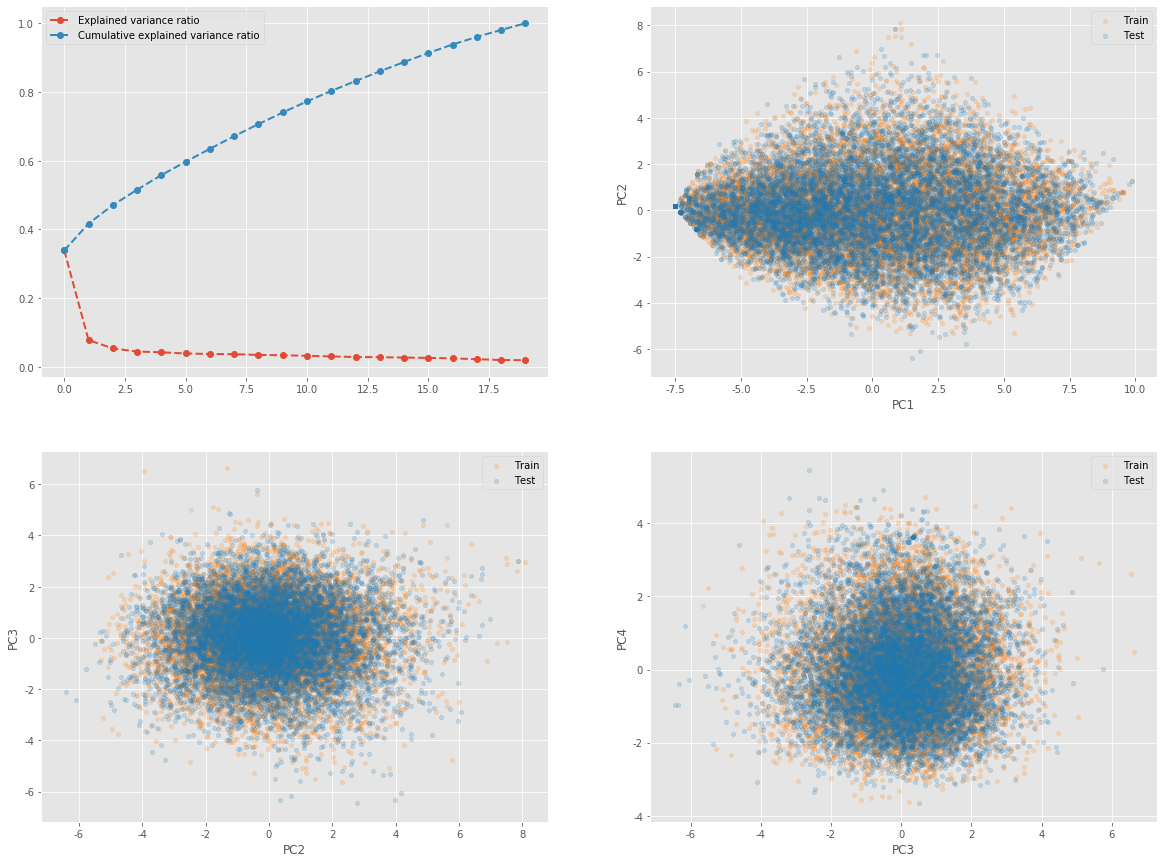

In [78]:
pca_df = test_pca(total_df)

In [ ]:
# qe 변수를 넣었더니 한쪽으로 굉장히 치우친 구조를 보임
# pca가 정수형 데이터밖에 안되나??
pca_df = test_pca(total_df)

- 실수형 데이터만 뽑아서 train, test 주성분 분포를 비교해봣는데 테스트 데이터셋이 약간 가운데로 몰아져있는 형태를 보인다

# t-sne 비교
- 공부를 좀 해야할 듯
- 조대협: https://bcho.tistory.com/1210
- t-sne도 pca와 마찬가지로 차원축소 방법론중 하나
    - pca와 다른점은 pca는 선형분석방법을 통해서 차원에 존재하는 데이터를 N-1차원으로 줄이면서 분산을 최대로 하면서(데이터를 최대한 보존하면서) 차원을 줄이는 것을 목적으로 하고 있음
    - 하지만 예를들어 2차원에 흩뿌려진 데이터를 1차원 선상으로 옮겨질 때 만약 해당 데이터의 구조가 어떤 군집으로 나뉘어진 데이터라고 가정했을 때 그 군집을 보존할 수 없게 된다. 즉, 데이터의 보존성을 잃는 것과 마찬가지이다.
    - 이를 보완하기 위해서 t-sne방법론이 나왔는데, 특정 군집내에서 데이터간의 거리를 축으로 삼아 t분포에 맞춰서 기준이 되는 점(데이터)를 t분포 중심에 있다고 가정하고 주변 데이터간의 t분포상의 유사도를 기반으로 가까운 것들끼리 묶는다.
    - PCA와 달리 군집의 특성을 유지하지만 매번 중심축이 달라지기 때문에(랜덤하게 기준점을 잡기 때문에) 분석 방법론으로 적합하지만 모델에 넣는 데이터셋으로는 적합하지 않음

NameError: name 'pca_df_all' is not defined

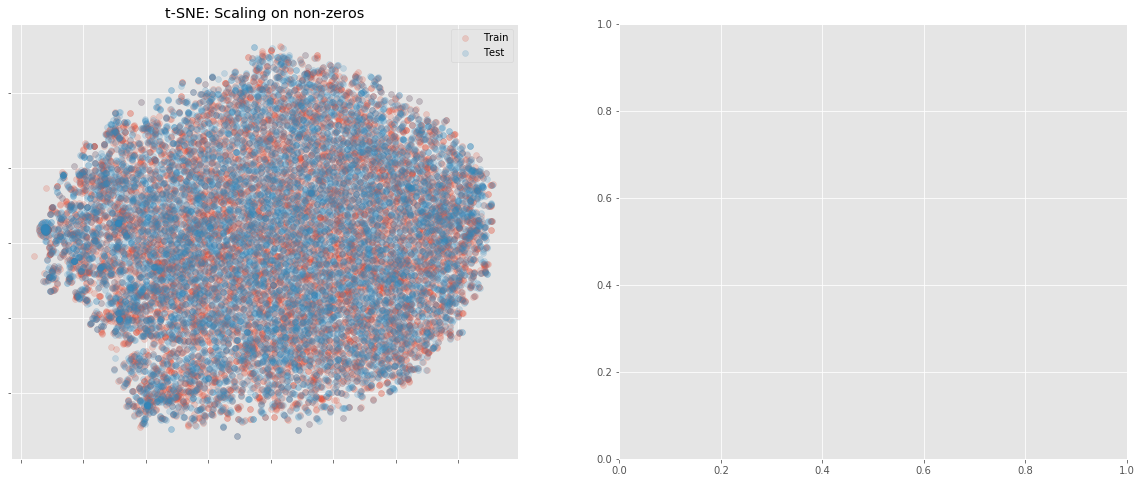

In [88]:
def test_tsne(data, ax=None, title='t-SNE'):
    """Run t-SNE and return embedding"""

    # Run t-SNE
    tsne = TSNE(n_components=2, init='pca')
    Y = tsne.fit_transform(data)

    # Create plot
    for name, idx in zip(["Train", "Test"], [train_idx, test_idx]):
        ax.scatter(Y[idx, 0], Y[idx, 1], label=name, alpha=0.2)
        ax.set_title(title)
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
    ax.legend()        
    return Y

# Run t-SNE on PCA embedding
_, axes = plt.subplots(1, 2, figsize=(20, 8))

tsne_df = test_tsne(
    pca_df, axes[0],
    title='t-SNE: Scaling on non-zeros'
)
tsne_df_unique = test_tsne(
    pca_df_all, axes[1],
    title='t-SNE: Scaling on all entries'
)

plt.axis('tight')
plt.show() 

# train test classification

In [151]:
total_df_all = deepcopy(total_df)

In [99]:
y = np.zeros(len(total_df_all))
y[train_idx] = 1

In [102]:
# Perform shuffled CV predictions of train/test label
# 간단하게 extra tree로 학습 후 예측
predictions = cross_val_predict(
    ExtraTreesClassifier(n_estimators=100, n_jobs=4),
    total_df_all, y,
    cv=StratifiedKFold(
        n_splits=10,
        shuffle=True,
        random_state=42
    )
)

In [103]:
# Show the classification report
# train data와 test 데이터셋의 분포가 랜덤성있게 잘 반영되어 있는 것을 확인할 수 있음
# train, test 예측을 거의 랜덤에 가깝게 하고 있음
print(classification_report(y, predictions))

              precision    recall  f1-score   support

         0.0       0.50      0.52      0.51     10000
         1.0       0.50      0.48      0.49     10000

    accuracy                           0.50     20000
   macro avg       0.50      0.50      0.50     20000
weighted avg       0.50      0.50      0.50     20000



# feature by feature distribution

In [105]:
def get_diff_columns(train_df, test_df, show_plots=True, show_all=False, threshold=0.1):
    """Use KS to estimate columns where distributions differ a lot from each other"""

    # Find the columns where the distributions are very different
    diff_data = []
    for col in tqdm(train_df.columns):
        statistic, pvalue = ks_2samp(
            train_df[col].values, 
            test_df[col].values
        )
        if pvalue <= 0.05 and np.abs(statistic) > threshold:
            diff_data.append({'feature': col, 'p': np.round(pvalue, 5), 'statistic': np.round(np.abs(statistic), 2)})

    # Put the differences into a dataframe
    diff_df = pd.DataFrame(diff_data).sort_values(by='statistic', ascending=False)

    if show_plots:
        # Let us see the distributions of these columns to confirm they are indeed different
        n_cols = 7
        if show_all:
            n_rows = int(len(diff_df) / 7)
        else:
            n_rows = 2
        _, axes = plt.subplots(n_rows, n_cols, figsize=(20, 3*n_rows))
        axes = [x for l in axes for x in l]

        # Create plots
        for i, (_, row) in enumerate(diff_df.iterrows()):
            if i >= len(axes):
                break
            extreme = np.max(np.abs(train_df[row.feature].tolist() + test_df[row.feature].tolist()))
            train_df.loc[:, row.feature].apply(np.log1p).hist(
                ax=axes[i], alpha=0.5, label='Train', density=True,
                bins=np.arange(-extreme, extreme, 0.25)
            )
            test_df.loc[:, row.feature].apply(np.log1p).hist(
                ax=axes[i], alpha=0.5, label='Test', density=True,
                bins=np.arange(-extreme, extreme, 0.25)
            )
            axes[i].set_title(f"Statistic = {row.statistic}, p = {row.p}")
            axes[i].set_xlabel(f'Log({row.feature})')
            axes[i].legend()

        plt.tight_layout()
        plt.show()
        
    return diff_df


In [108]:
diff_data = []
for col in tqdm(tr.columns):
    statistic, pvalue = ks_2samp(
        tr[col].values, 
        te[col].values
    )
    if pvalue <= 0.05 and np.abs(statistic) > threshold:
        diff_data.append({'feature': col, 'p': np.round(pvalue, 5), 'statistic': np.round(np.abs(statistic), 2)})

100%|██████████| 20/20 [00:00<00:00, 211.52it/s]


- 해당 대회는 train, test 데이터간의 분포차이가 없었음

- 변수 로그화를 진행한 후에 실제로 hist를 그려보자

- train, test 분포 차이 분석을 진행하면서 flow가 중요하다는 것을 인식해야함
    - 이유는 학습셋과 테스트셋을 예측하는 간단한 모델을 만들어서 분포차이가 크다면 당연히 둘을 나누는 eval metric 결과가 도출되므로 그 값을 가지고 diff columns들을 찾아서 해당 사이클을 반복하는 플로우를 인식하자

# 각 변수별 로그화를 거친 후 분포도 확인
- 두 데이터셋 사이에 분포가 맞지 않아 통계값에 이상이 있었던 데이터가 없었지만, 실제로 분포도를 그려서 다시 확인해보자

In [163]:
def dist_plot(df, col):
    sns.kdeplot(df[col].iloc[train_idx],label = 'train')
    sns.kdeplot(df[col].iloc[test_idx], label = 'test')
    plt.show()

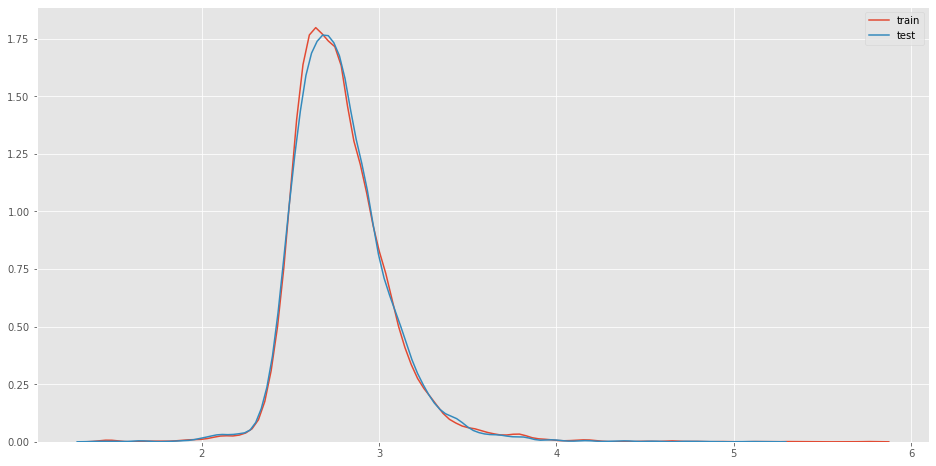

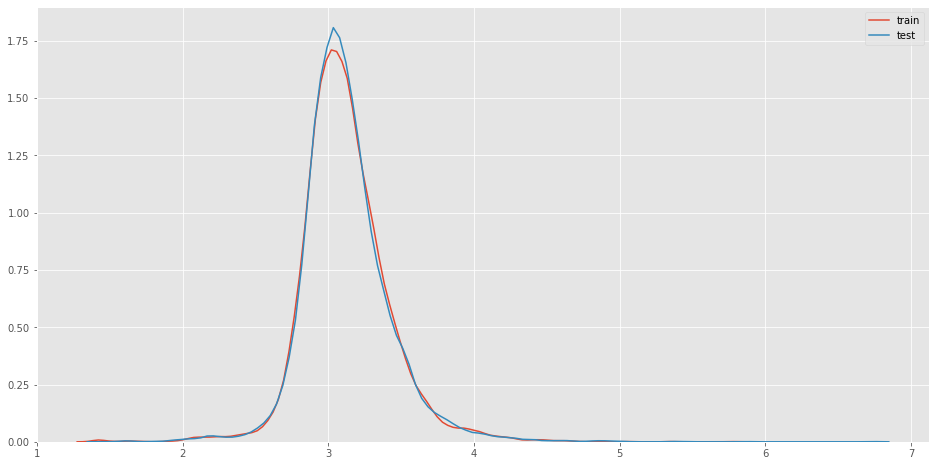

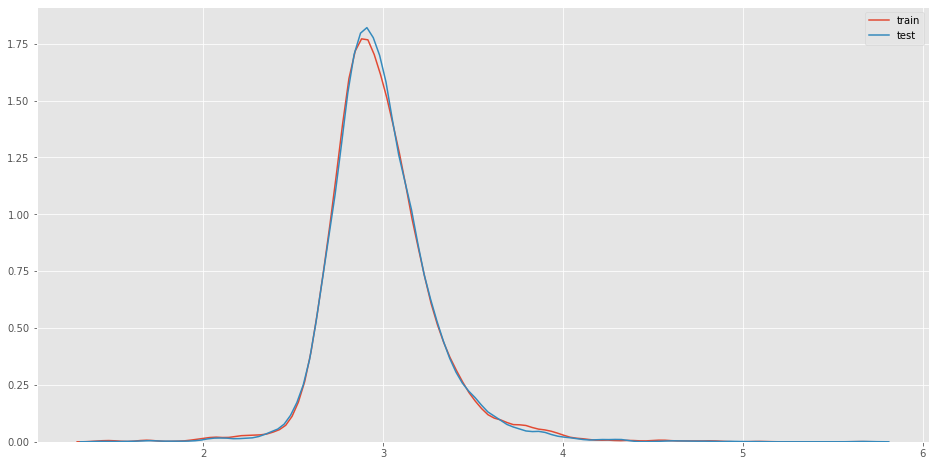

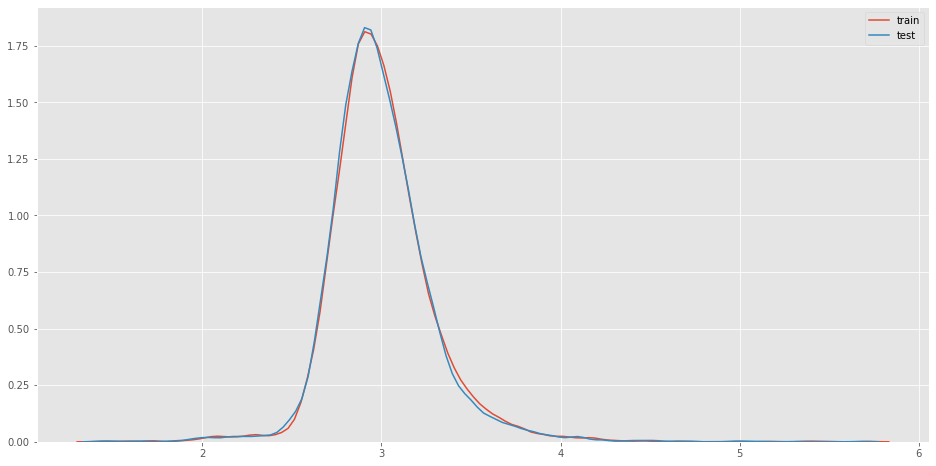

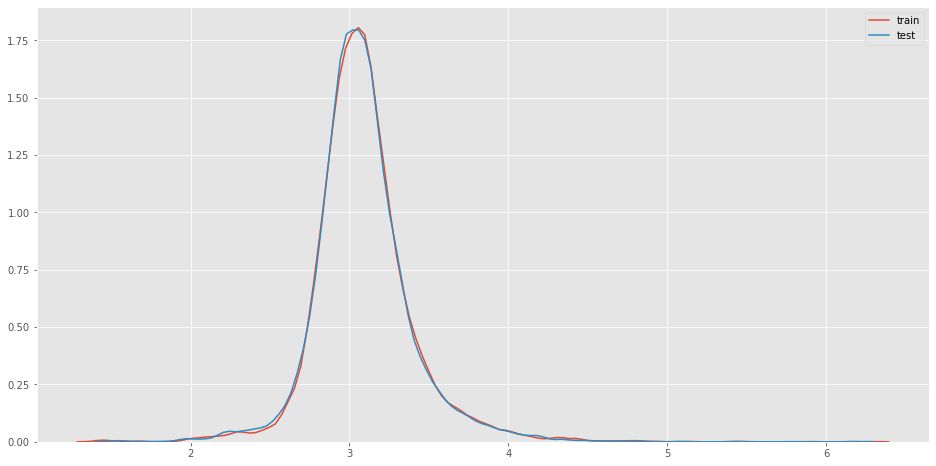

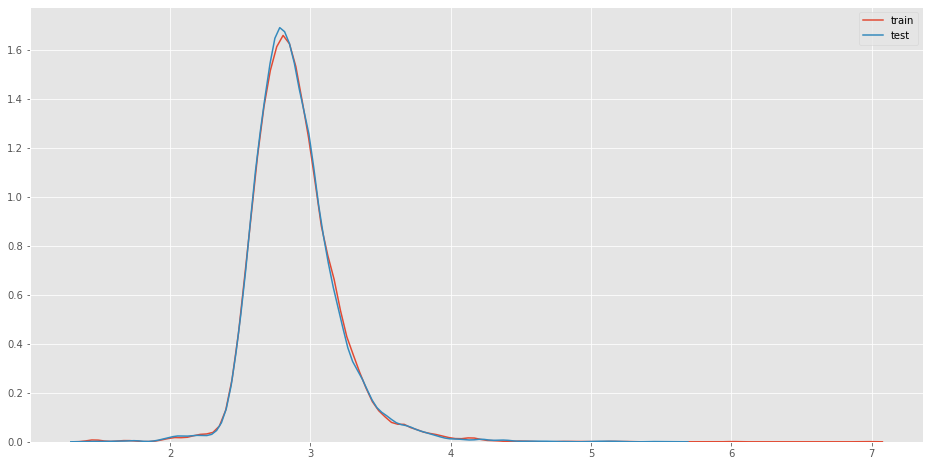

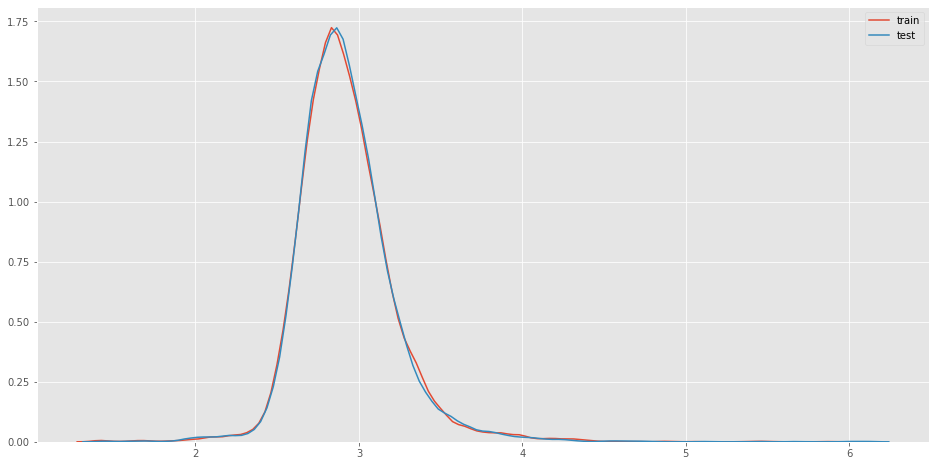

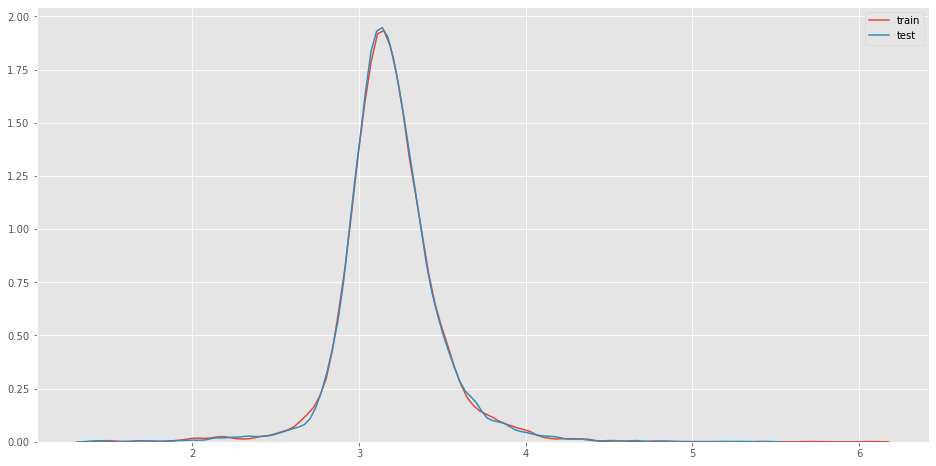

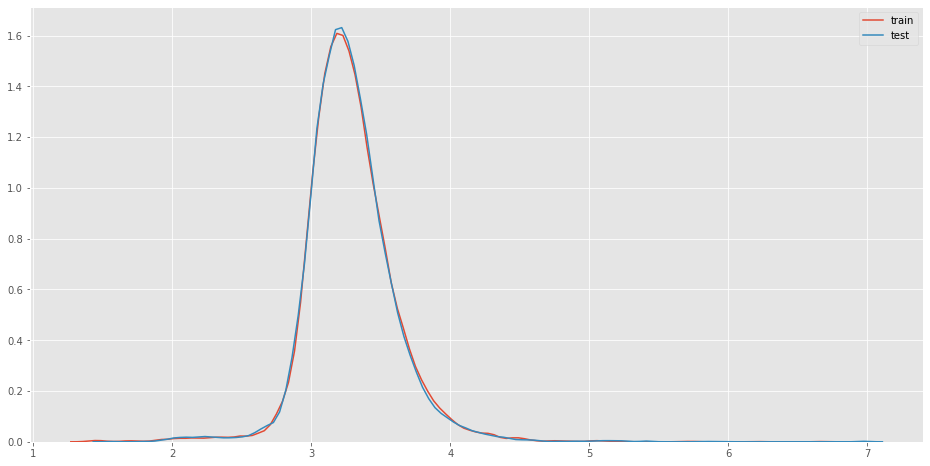

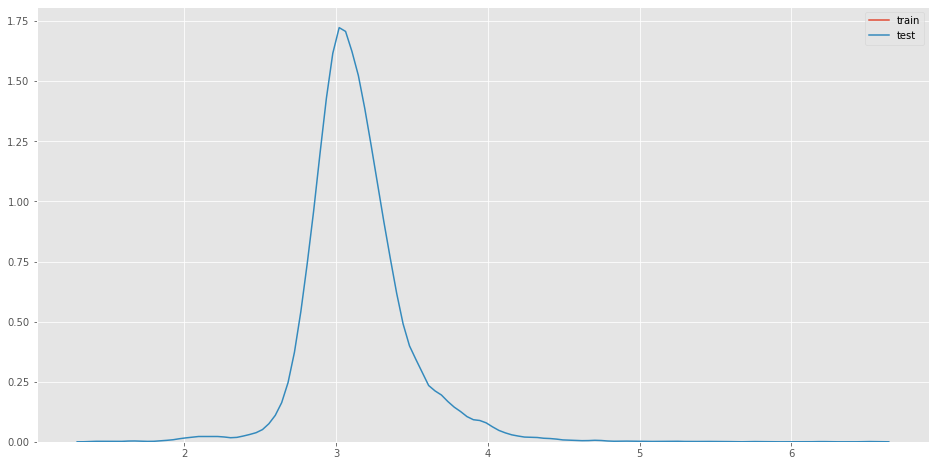

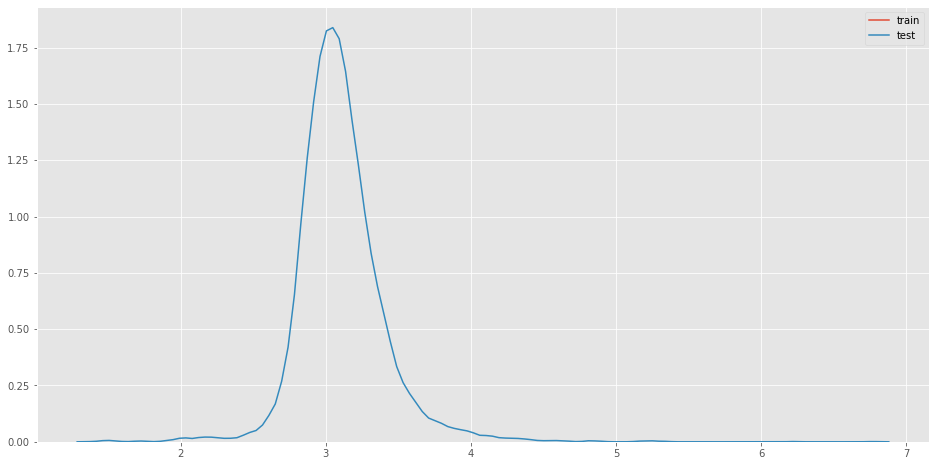

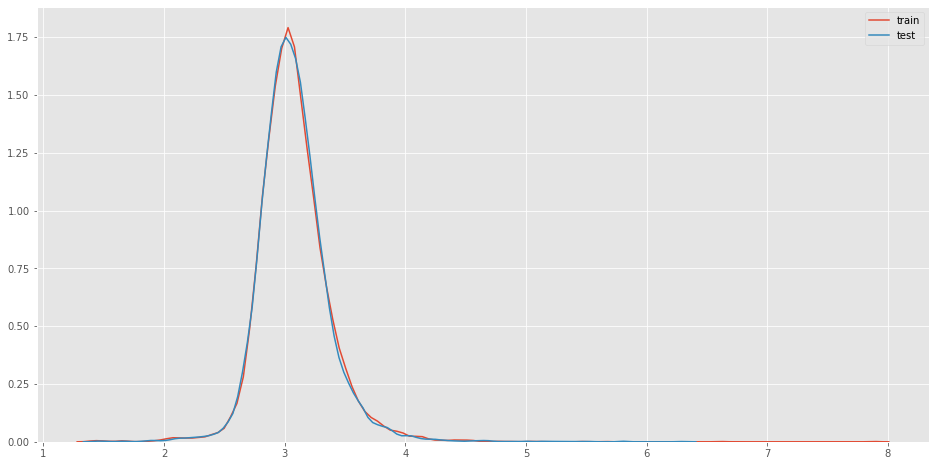

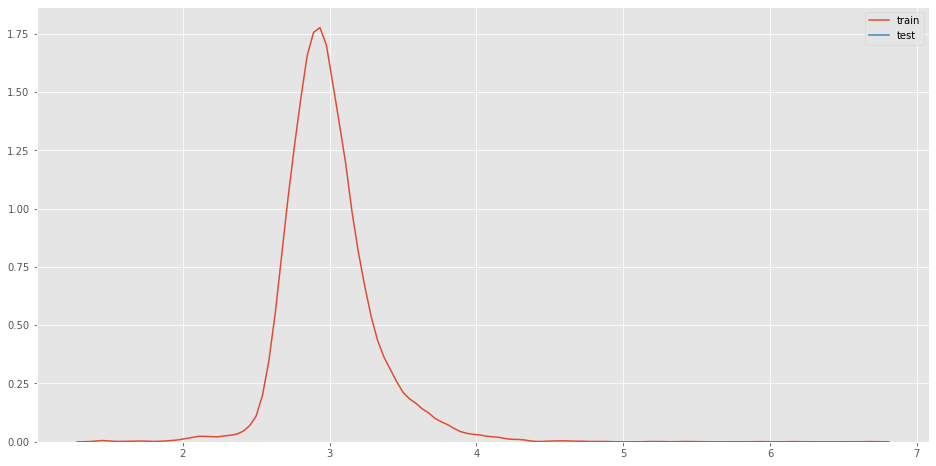

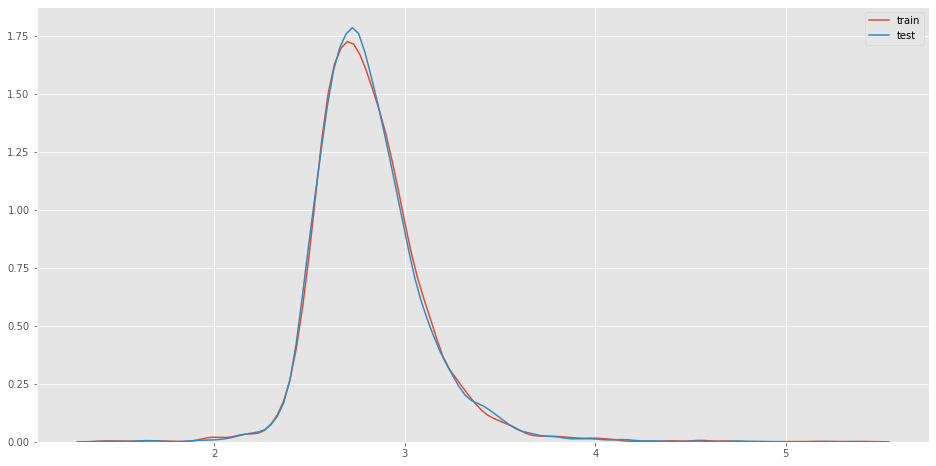

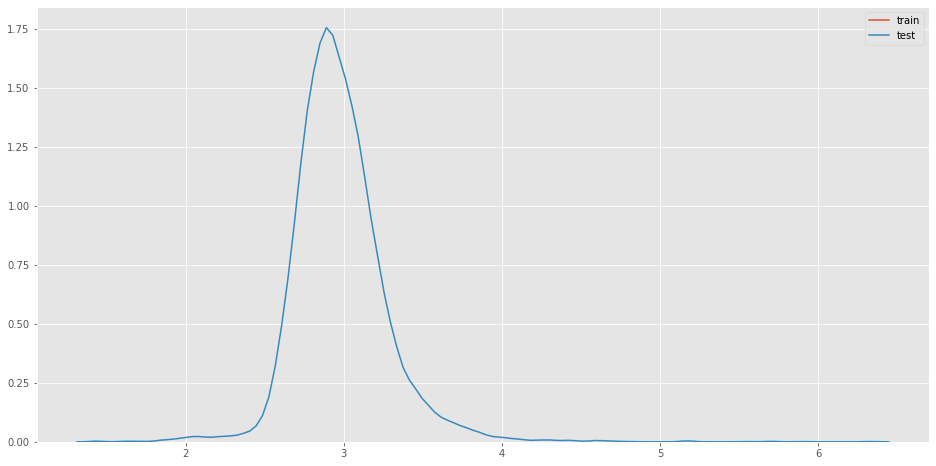

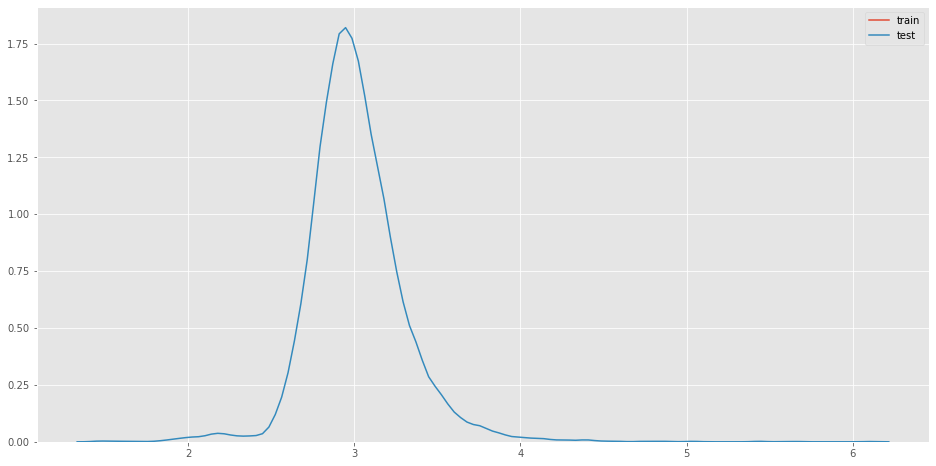

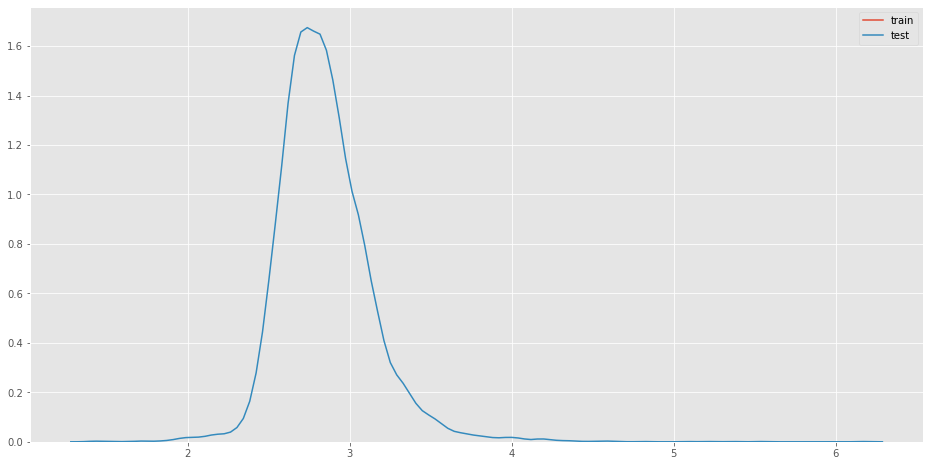

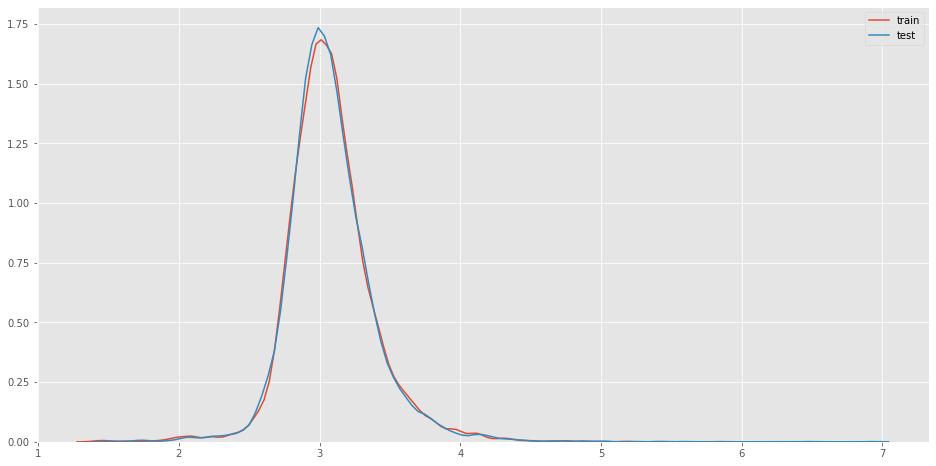

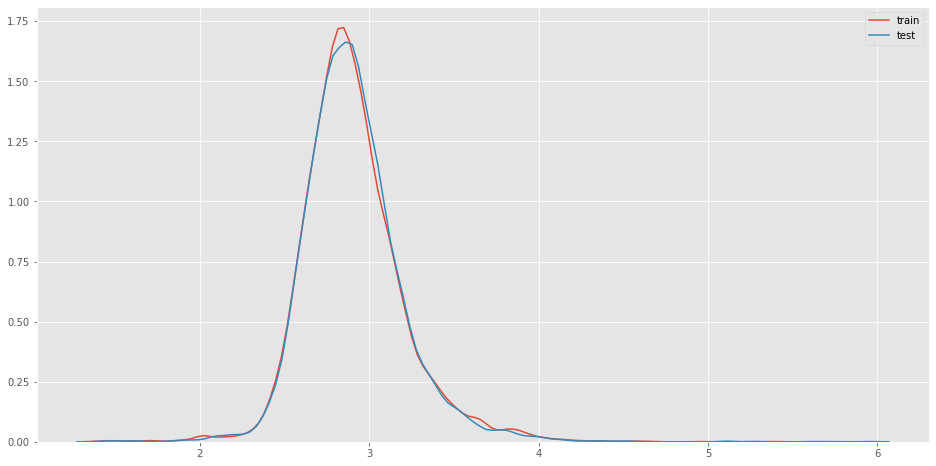

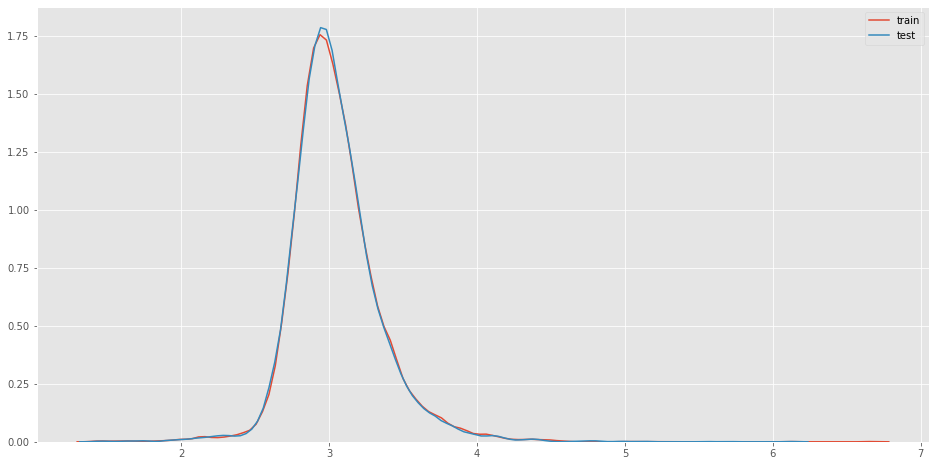

In [166]:
for col in qe_ls:
    dist_plot(total_df_all, col)

- Q_E 변수들은 train, test 분포가 거의 일정한 것을 확인할 수 있음

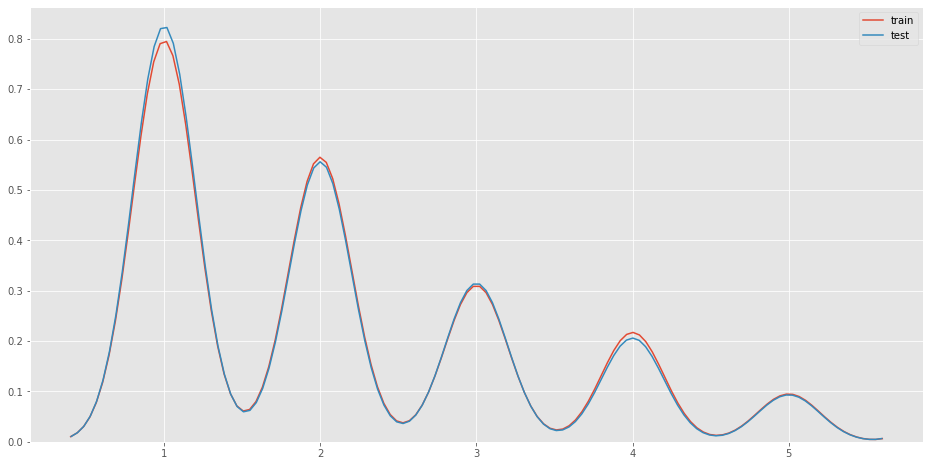

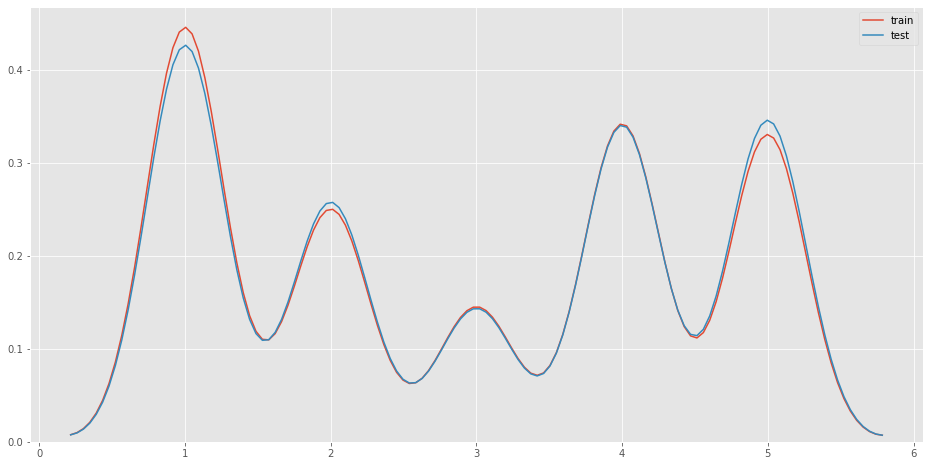

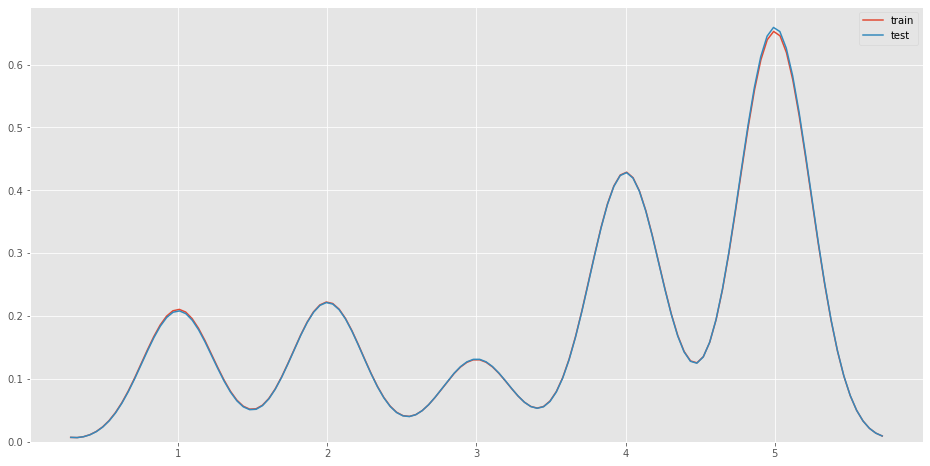

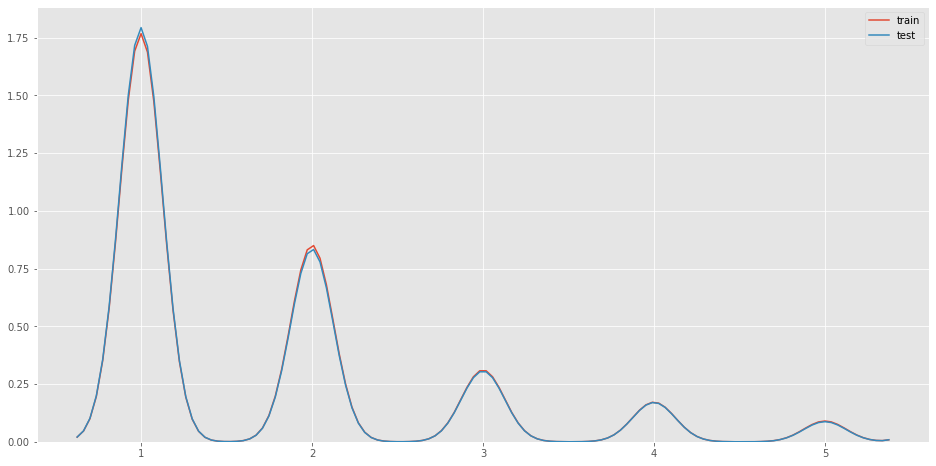

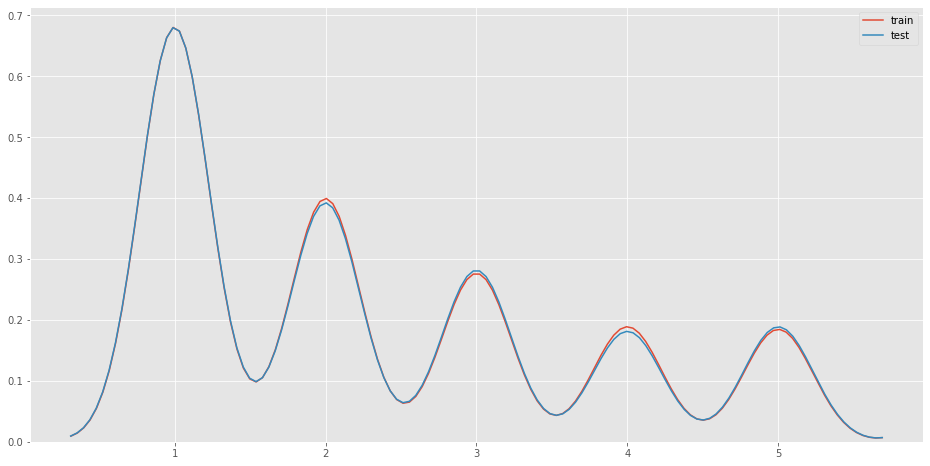

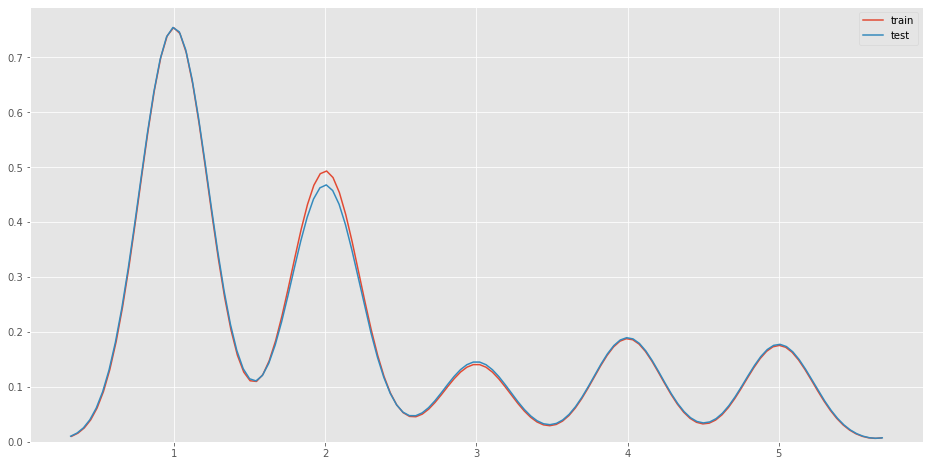

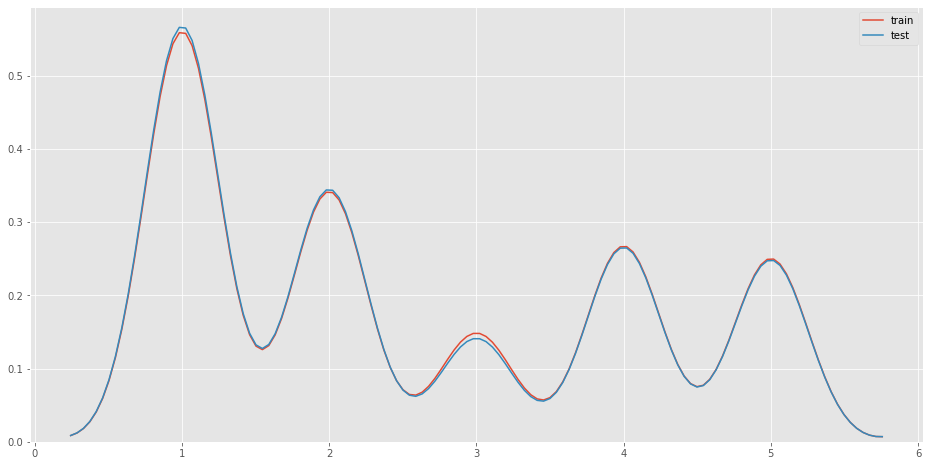

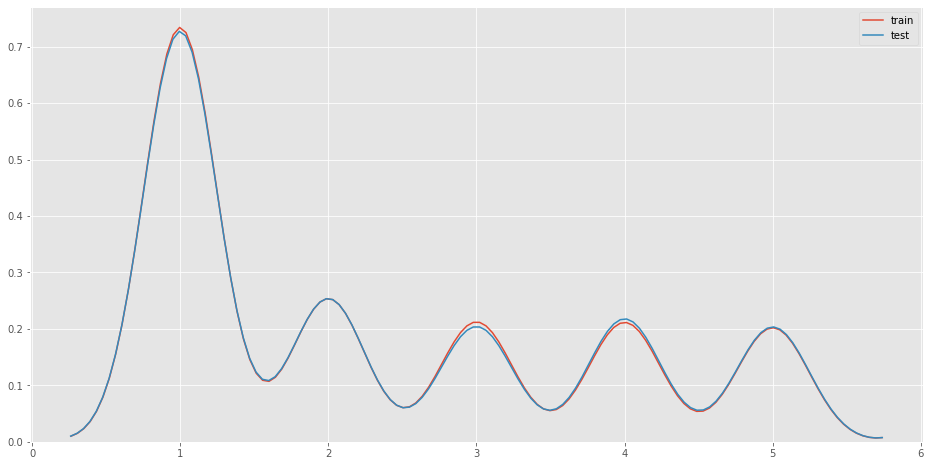

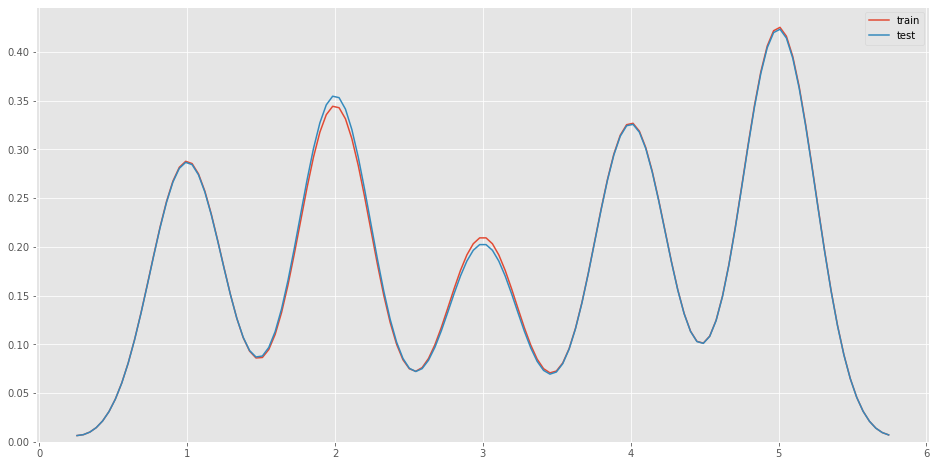

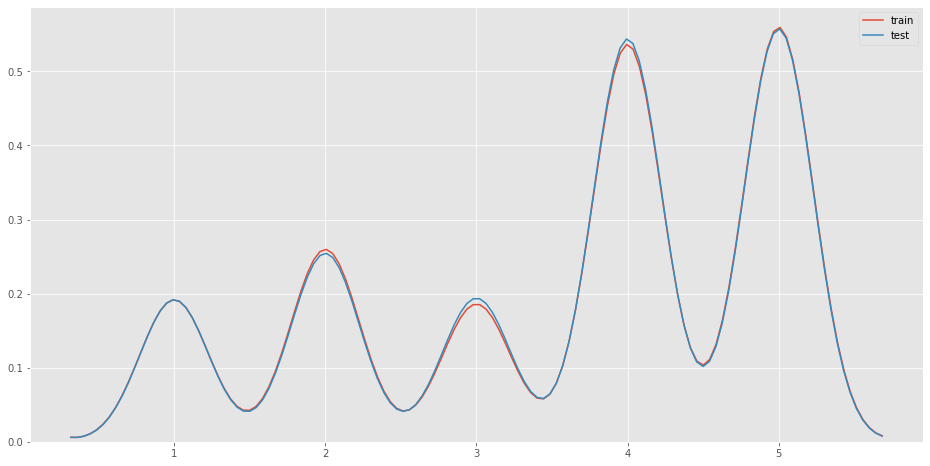

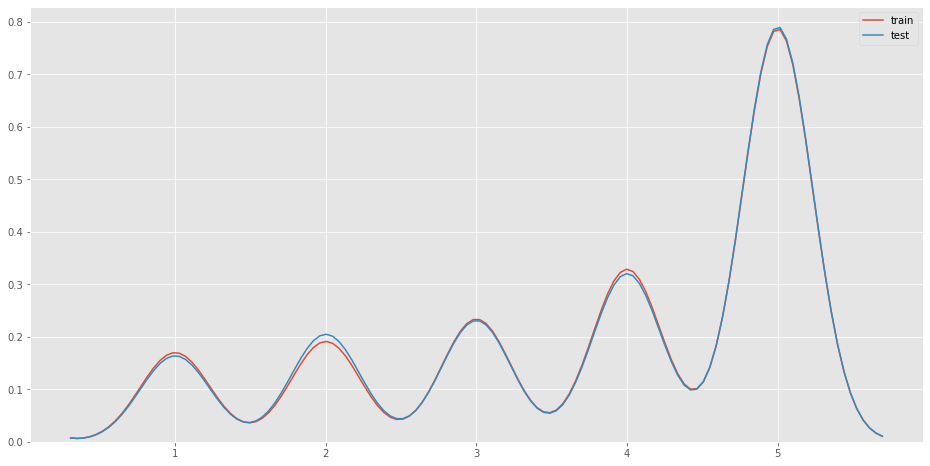

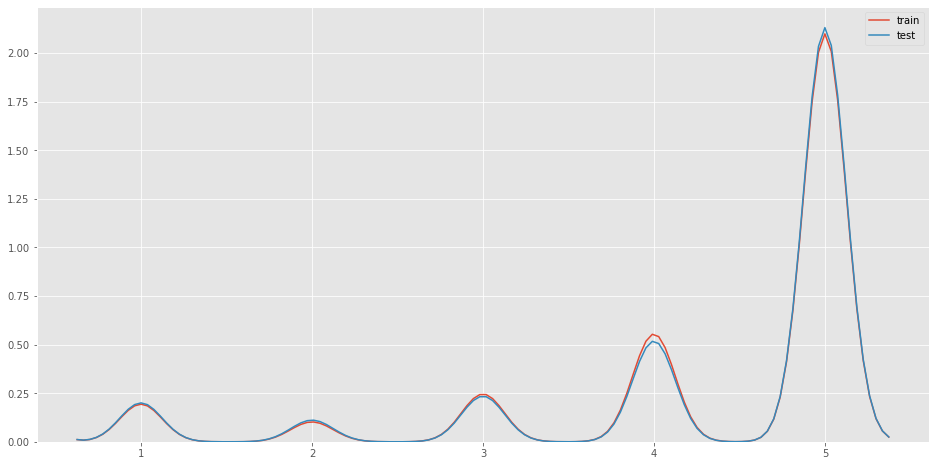

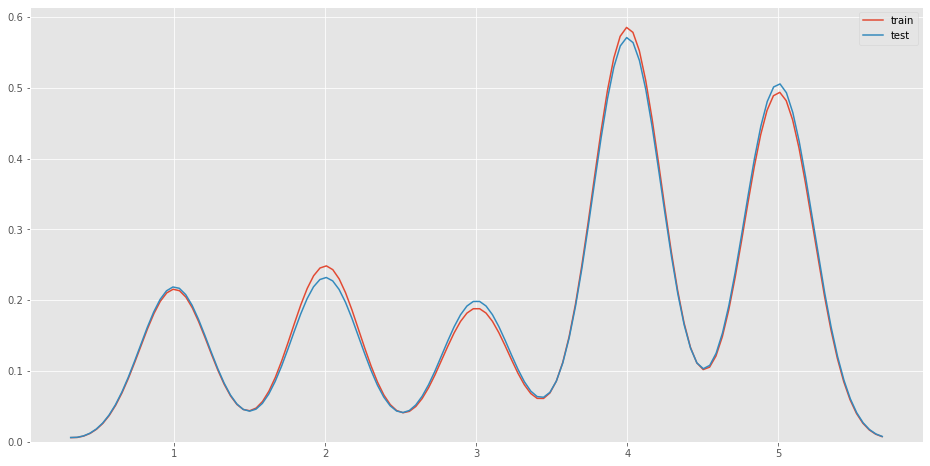

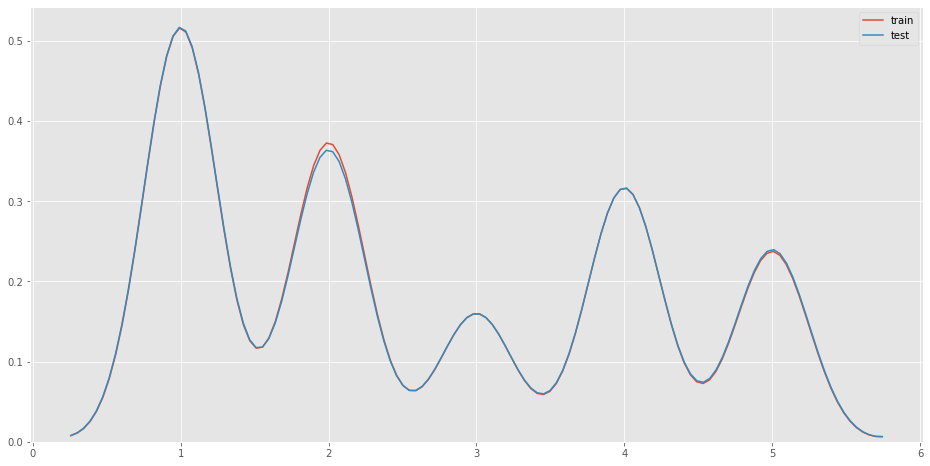

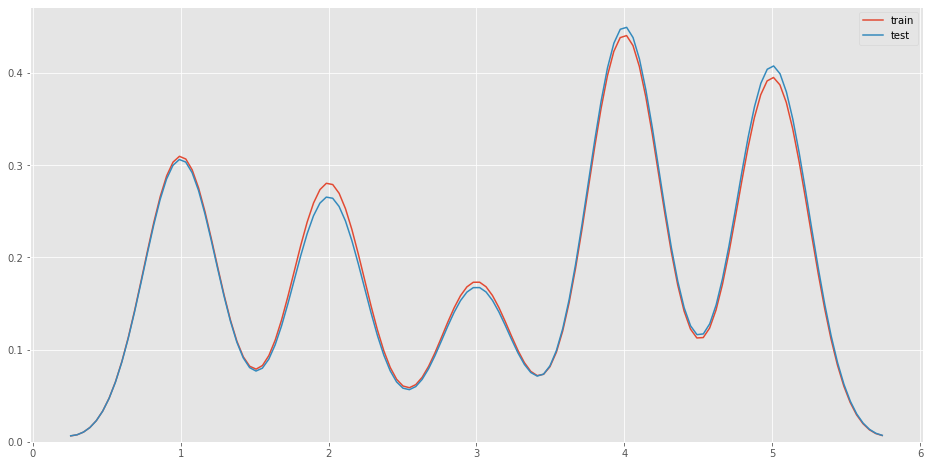

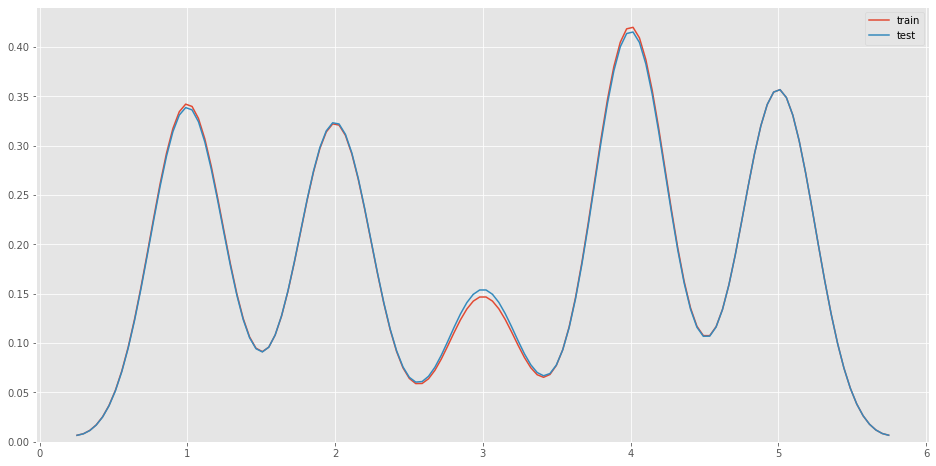

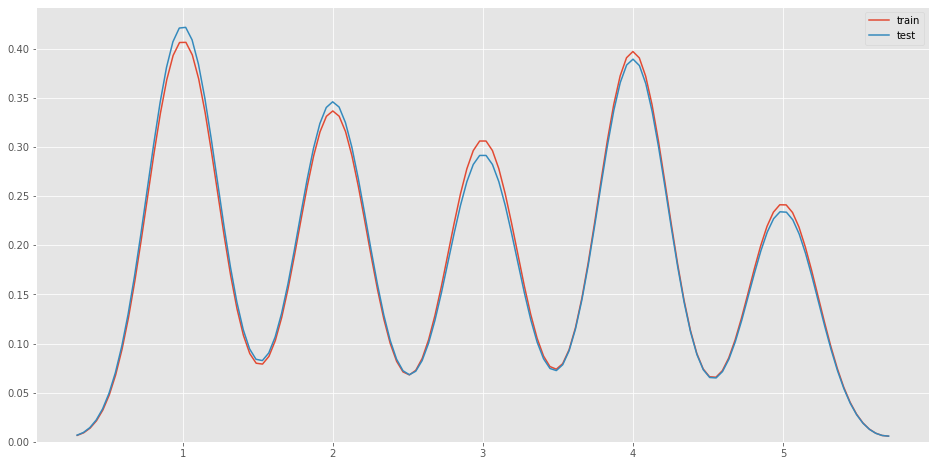

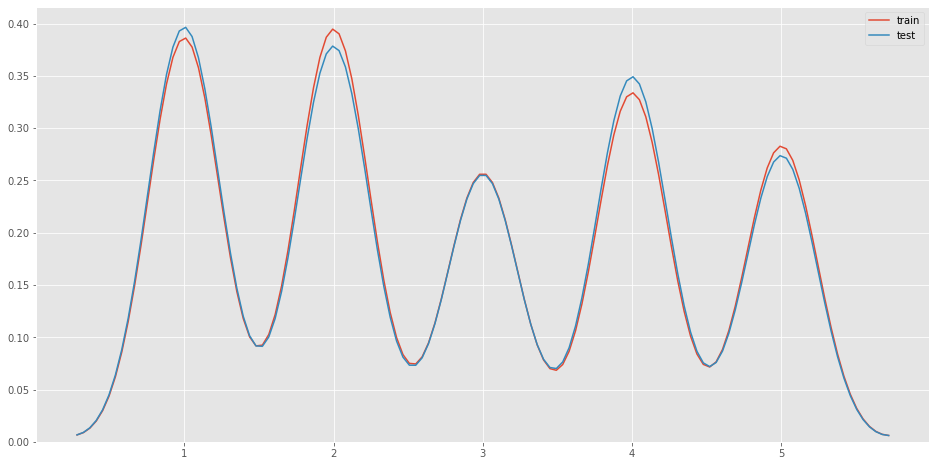

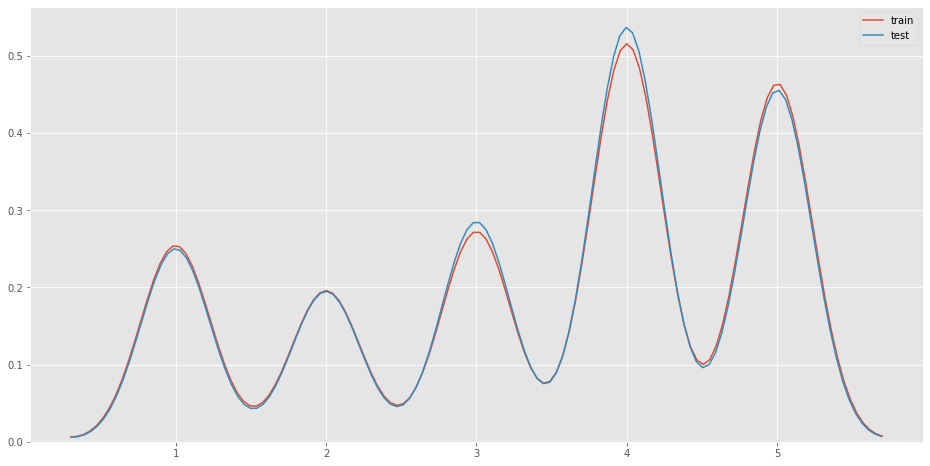

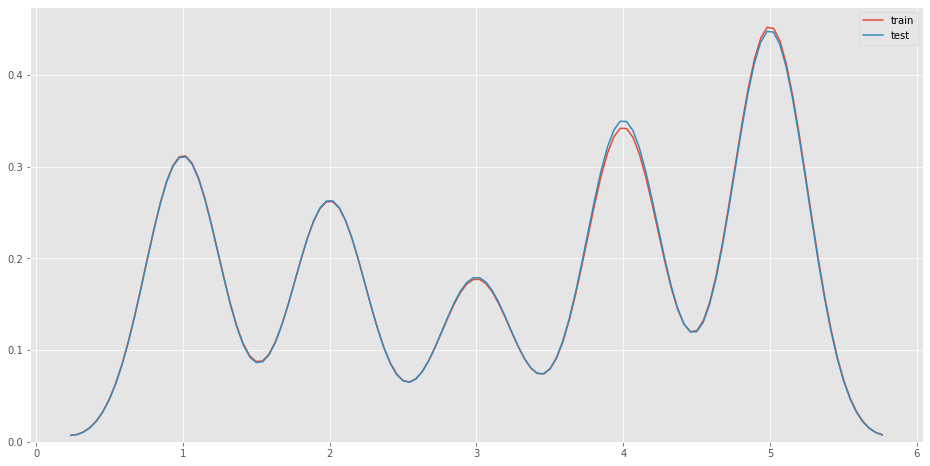

In [170]:
for col in qa_ls:
    dist_plot(total_df_all, col)

- Q_A변수들도 분포가 굉장히 비슷한 것을 알 수 있음